In [1]:
import numpy as np
import torch
import umap
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms

import torch.nn as nn

import torch.optim as optim
from torch import nn 
import torch.nn.functional as F
import torchvision.transforms.functional as tvF
import numpy as np
import torch.optim as optim
from IPython.display import clear_output, display
import time
import matplotlib.pyplot as plt
import copy

2024-03-19 12:27:31.360178: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 12:27:31.508848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 12:27:31.508932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 12:27:31.526487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 12:27:31.573410: I tensorflow/core/platform/cpu_feature_guar

In [2]:

model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in /home/vkeilo/.cache/torch/hub/pytorch_vision_v0.10.0
/home/vkeilo/miniconda3/envs/data_analyse/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vkeilo/miniconda3/envs/data_analyse/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

模型的基本架构

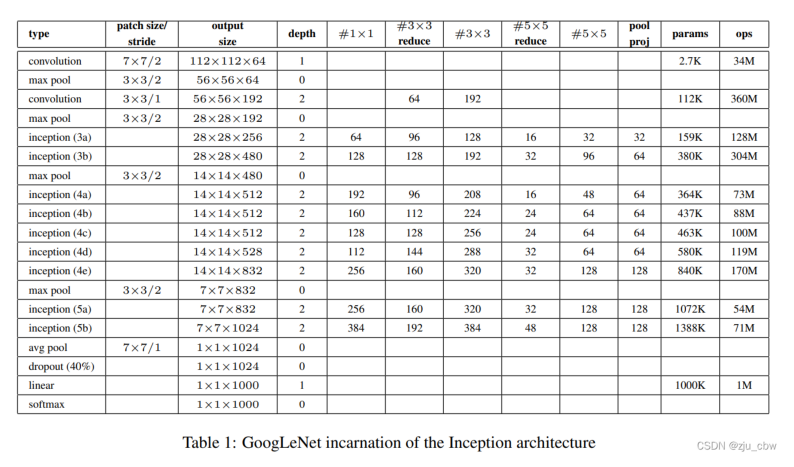

In [3]:
image_path = 'datas/datas/e0a1938b050e4ac1a059d5762b077b6b.png'
image = plt.imread(image_path)

plt.figure(figsize=(10, 8))  # 设置图片大小
plt.imshow(image)
plt.axis('off')  # 关闭刻度
plt.show()


In [5]:
# # 定义一个变量来存储激活
# activation = {}

# # 定义钩子获取特定层的激活
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output
#         print('update_dict!')
#     return hook

# # 注册钩子以捕获inception4c层的激活
# model.inception4c.register_forward_hook(get_activation('inception4c'))

准备一个小狗图片的中间激活

In [6]:
input_image = Image.open('/media/vkeilo/game/github_project/atlas/tmp/dog.jpeg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

update_dict!
tensor([9.6690e-04, 1.1293e-04, 1.8710e-04, 2.2083e-04, 4.9393e-04, 2.8508e-04,
        3.1183e-04, 5.6315e-05, 1.1179e-04, 2.3421e-05, 8.0798e-04, 3.7448e-04,
        2.1094e-04, 1.4353e-04, 6.2650e-04, 1.6850e-04, 2.9090e-05, 1.2392e-04,
        1.9115e-04, 6.8087e-05, 2.9462e-04, 1.3604e-04, 1.5583e-04, 1.2541e-04,
        1.9936e-04, 1.1877e-03, 1.3056e-03, 5.8600e-04, 5.5428e-04, 2.7714e-04,
        1.9121e-04, 3.6108e-04, 5.5253e-04, 1.8229e-04, 1.7592e-04, 4.0220e-04,
        3.6682e-04, 2.4412e-04, 6.7051e-04, 1.1791e-04, 5.7709e-04, 4.2409e-04,
        4.8145e-04, 3.0932e-04, 7.4692e-04, 1.3494e-04, 4.2432e-04, 2.0503e-04,
        1.1517e-04, 5.3990e-04, 8.2152e-04, 4.9207e-04, 3.8657e-04, 7.6539e-04,
        2.3669e-04, 2.1071e-04, 1.3444e-04, 3.1032e-04, 2.8276e-04, 4.9754e-04,
        2.3821e-04, 1.9191e-04, 7.4621e-04, 1.7825e-04, 3.5625e-04, 4.3541e-04,
        3.4555e-04, 2.0017e-04, 3.4389e-04, 3.0759e-04, 3.4831e-04, 5.1136e-04,
        7.8439e-04, 7.3379e

准备在GPU上进行后续处理

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 加载预训练模型并设置为评估模式
# model = models.googlenet(pretrained=True)
model.eval()
model.to(device)
# model.train()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

#### 一系列损失函数定义

In [5]:

class MaximizeDotProductLoss(nn.Module):
    def __init__(self):
        super(MaximizeDotProductLoss, self).__init__()

    def forward(self, output, target):
        # 计算点积
        dot_product = torch.sum(output * target)
        # 返回负的点积作为损失
        return -dot_product
    
# torch.sum(input_tensor)

class All_tensor_sum(nn.Module):
    def __init__(self):
        super(All_tensor_sum, self).__init__()

    def forward(self, output):

        sum = torch.sum(output)

        return -sum
    
class CustomLoss(nn.Module):
    def __init__(self, n=1, S = None):
        super(CustomLoss, self).__init__()
        self.n = n
        self.S = torch.tensor(S).to(device) if S is not None else None
    
    def forward(self, h, v, S = None):
        # 对方向向量进行白化
        if self.S is not None:
            v = torch.matmul(v.unsqueeze(0), self.S).squeeze(0)
            h = torch.matmul(h.unsqueeze(0), self.S).squeeze(0)
        # 计算点积
        dot_product = torch.dot(h, v)
        
        # 计算余弦相似度
        cosine_similarity = torch.cosine_similarity(h, v, dim=0)
        
        # 计算损失
        loss = -((dot_product ** self.n) + 1 * ((torch.norm(h) * torch.norm(v)) ** self.n) * (cosine_similarity ** self.n) * (dot_product ** (self.n + 1)))
        
        return loss
    

class CustomLossWithRegularization(nn.Module):
    def __init__(self, n=1, S=None, reg_coeff=0.001):
        super(CustomLossWithRegularization, self).__init__()
        self.n = n
        self.S = torch.tensor(S).to(device) if S is not None else None
        self.reg_coeff = reg_coeff
    
    def forward(self, h, v, S=None):
        # 对方向向量进行白化
        # print(f'h is {h.shape}')
        # print(f'v is {v.shape}')

        if self.S is not None:
            v = torch.matmul(v.unsqueeze(0), self.S).squeeze(0)
            h = torch.matmul(h.unsqueeze(0), self.S).squeeze(0)
        
        # 计算点积
        dot_product = torch.dot(h, v)
        
        # 计算余弦相似度
        cosine_similarity = torch.cosine_similarity(h, v, dim=0)
        
        # 计算 L2 正则化项
        l2_regularization = self.reg_coeff * (torch.norm(h) ** 2 + torch.norm(v) ** 2)
        
        # 计算损失
        loss = -((dot_product ** self.n) + 1 * ((torch.norm(h) * torch.norm(v)) ** self.n) * (cosine_similarity ** self.n) * (dot_product ** (self.n + 1)))
        
        # 添加正则化项到损失中
        loss += l2_regularization
        
        return loss


In [83]:



# 创建一个原始随机图像，允许梯度更新
# random_image = torch.randn(1, 3, 224, 224, requires_grad=True)
random_image = torch.randn(1, 3, 224, 224, device=device, requires_grad=True).to(device)
# 创建一个目标激活向量
# target_activation = torch.randn(1, 512, 14, 14).detach()  # 确保目标激活不需要梯度
# target_activation = test_v
target_activation = test_v[:,200:250,7,7].to(device)




In [24]:
class FeatureImgCreator():
    def __init__(self, model,layer_name = 'inception4c',loss_fn=F.mse_loss,initial_img = None):
        self.model = model
        self.layer_name = layer_name
        self.loss_fn = loss_fn
        self.optimizer = None
        self.random_image = torch.randn(1, 3, 224, 224, device=device, requires_grad=True).to(device)
        if initial_img is not None:
            tmp_image = torch.zeros(1, 3, 224, 224, device=device)
            tmp_image[:, initial_img, :, :] = 1
            self.random_image = tmp_image
            self.random_image.requires_grad = True
        # 定义一个变量来存储激活
        self.activation = {}
        # 注册钩子以捕获inception4c层的激活
        self.model.inception4c.register_forward_hook(self.get_activation())
    # 定义钩子获取特定层的激活
    def get_activation(self):
        def hook(model, input, output):
            self.activation[self.layer_name] = output
        return hook

    
    def imgae_create(self, target_activation, learning_rate = 0.02, steps = 500, slices_set = slice(None),atlas_mode = None, show_step = 0):
        # self.optimizer = optim.Adagrad([self.random_image], lr=learning_rate)
        # 优化器选择与论文相同的
        self.optimizer = optim.Adam([self.random_image], lr=learning_rate)
        # 优化循环
        for iteration in range(steps):
            self.optimizer.zero_grad()
            _ = self.model(self.random_image)
            # print(output)
            if atlas_mode == 'means':
                current_activation = torch.mean(self.activation[self.layer_name], dim=(2, 3), keepdim=True).squeeze()
            elif atlas_mode == 'max':
                current_activation = torch.max(self.activation[self.layer_name].reshape(512,196), 1)[0]
            else:
                current_activation = self.activation[self.layer_name]
            # print(current_activation.shape)
            # print(target_activation.shape)
            if target_activation is not None:
                loss = self.loss_fn(current_activation[slices_set], target_activation)
            else:
                loss = self.loss_fn(current_activation[slices_set])
            loss.requires_grad_(True)
            loss.backward()
            # print("梯度值:", random_image.grad)
            self.optimizer.step()
            if show_step > 0 and iteration % show_step == 0:
                clear_output(wait=True)
                self.imshow()
            # if iteration % 100 == 0:
                print(f"Iteration: {iteration}, Loss: {loss.item()}")

    def imshow(self, ax=None, title=None):
        tensor = self.random_image.squeeze()
        image = tensor.cpu().detach().numpy() # 转换为numpy数组
        image = image.transpose((1, 2, 0))    # 重排维度为HxWxC
        image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # 反标准化
        image = np.clip(image, 0, 1)          # 将值裁剪到[0,1]范围内
        if ax is None:
            plt.imshow(image)
            if title is not None:
                plt.title(title)
            plt.pause(0.001) # pause a bit so that plots are updated
        else:
            ax.imshow(image)
            if title:
                ax.set_title(title)

取一系列激活值样本

In [9]:
from joblib import dump, load

# model.layers[7] is "mixed4c"
# raw_activations = model.layers[7].activations
raw_activations = load('datas/datas/raw_activations.joblib')
activations_10k = raw_activations[:100000]
print(activations_10k.shape)

(100000, 512)


数据白化

In [10]:
def whiten(full_activations):
    correl = np.matmul(full_activations.T, full_activations) / len(full_activations)
    correl = correl.astype("float32")
    S = np.linalg.inv(correl)
    S = S.astype("float32")
    return S

In [11]:
S = whiten(activations_10k)

#### 网格化

In [12]:
# 归一化处理 
def normalize_layout(layout, min_percentile=1, max_percentile=99, relative_margin=0.1):
    """Removes outliers and scales layout to between [0,1]."""

    # compute percentiles
    mins = np.percentile(layout, min_percentile, axis=(0))
    maxs = np.percentile(layout, max_percentile, axis=(0))

    # add margins
    mins -= relative_margin * (maxs - mins)
    maxs += relative_margin * (maxs - mins)

    # `clip` broadcasts, `[None]`s added only for readability
    clipped = np.clip(layout, mins, maxs)

    # embed within [0,1] along both axes
    clipped -= clipped.min(axis=0)
    clipped /= clipped.max(axis=0)

    return clipped

def grid(xpts=None, ypts=None, grid_size=(8,8), x_extent=(0., 1.), y_extent=(0., 1.)):
    xpx_length = grid_size[0]
    ypx_length = grid_size[1]

    xpt_extent = x_extent
    ypt_extent = y_extent

    xpt_length = xpt_extent[1] - xpt_extent[0]
    ypt_length = ypt_extent[1] - ypt_extent[0]

    xpxs = ((xpts - xpt_extent[0]) / xpt_length) * xpx_length
    ypxs = ((ypts - ypt_extent[0]) / ypt_length) * ypx_length

    ix_s = range(grid_size[0])
    iy_s = range(grid_size[1])
    xs = []
    for xi in ix_s:
        ys = []
        for yi in iy_s:
            xpx_extent = (xi, (xi + 1))
            ypx_extent = (yi, (yi + 1))

            in_bounds_x = np.logical_and(xpx_extent[0] <= xpxs, xpxs <= xpx_extent[1])
            in_bounds_y = np.logical_and(ypx_extent[0] <= ypxs, ypxs <= ypx_extent[1])
            in_bounds = np.logical_and(in_bounds_x, in_bounds_y)

            in_bounds_indices = np.where(in_bounds)[0]
            ys.append(in_bounds_indices)
        xs.append(ys)
    return xs



In [13]:
layout = umap.UMAP(n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(activations_10k)

## You can optionally use TSNE as well
# layout = TSNE(n_components=2, verbose=True, metric="cosine", learning_rate=10, perplexity=50).fit_transform(d)

layout = normalize_layout(layout)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Tue Mar 19 12:28:20 2024 Construct fuzzy simplicial set
Tue Mar 19 12:28:20 2024 Finding Nearest Neighbors
Tue Mar 19 12:28:20 2024 Building RP forest with 21 trees
Tue Mar 19 12:28:23 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Tue Mar 19 12:28:31 2024 Finished Nearest Neighbor Search
Tue Mar 19 12:28:33 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Mar 19 12:29:07 2024 Finished embedding


In [14]:
xs = layout[:, 0]
ys = layout[:, 1]
grid_size = (512, 512)
grid_layout = grid(xpts=xs, ypts=ys, grid_size=grid_size)

In [15]:
# 计算平均激活

icons = []
min_density = 3
for x in range(grid_size[0]):
    for y in range(grid_size[1]):
        indices = grid_layout[x][y]
        density_size = len(indices)
        if len(indices) > min_density:
            average_activation = np.average(activations_10k[indices], axis=0)
            icons.append((average_activation, x, y, density_size))

In [16]:
for i,t in enumerate(icons):
    # print(f'{i} have {t[3]} items')
    if t[3] > 10:
        print(f'{i} have {t[3]} items')

111 have 12 items
126 have 12 items
741 have 12 items
835 have 12 items
836 have 12 items
837 have 11 items
842 have 12 items
843 have 12 items
844 have 11 items
853 have 14 items
1651 have 11 items
1684 have 14 items
1690 have 13 items


In [17]:
test_v = icons[853][0]

In [57]:
# test_v = activation['inception4c']
test_v = activations_10k[1200]

In [18]:
test_v.shape

(512,)

In [ ]:
# https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/regularization.ipynb#scrollTo=3d6xz3CvTLu5

1. 使用CustomLossWithRegularization带正则的损失函数对某层**所有通道**下**特定位置神经元**针对目标激活进行优化

In [24]:


# in4c_img_creator = FeatureImgCreator(model,loss_fn=lambda x, y: F.cosine_similarity(x, y, dim=0))
in4c_img_creator_special_place = FeatureImgCreator(model,loss_fn=CustomLossWithRegularization(S=S,reg_coeff=0.05))
# in4c_img_creator = FeatureImgCreator(model,loss_fn=torch.nn.L1Loss)

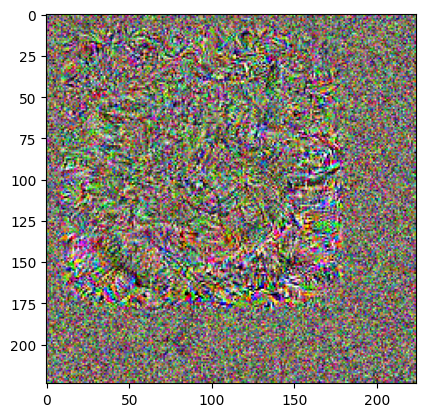

Iteration: 195, Loss: -0.005339655559509993


In [25]:
# 1*512*14*14
tmp_slices = (0,slice(None),5,5)
in4c_img_creator_special_place.imgae_create(torch.tensor(test_v).to(device),slices_set = tmp_slices, steps = 200, learning_rate=0.05,show_step=5)
# in4c_img_creator.imshow()

2. 使用MSE损失函数对某层**特定通道**下**的通道平均激活**针对目标激活进行优化

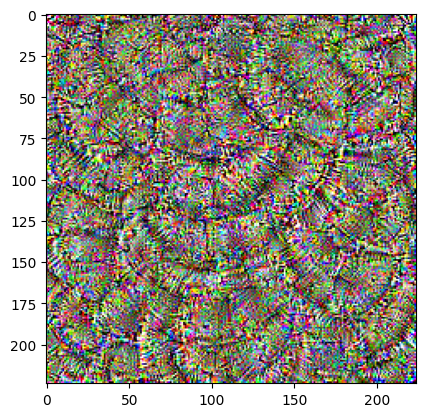

Iteration: 195, Loss: 459.2983093261719


In [43]:
in4c_img_creator_meanatlas_onechannal = FeatureImgCreator(model,loss_fn=torch.nn.MSELoss(reduction='mean'),initial_img = None)
tmp_slices = (20)
in4c_img_creator_meanatlas_onechannal.imgae_create(torch.tensor(test_v[tmp_slices]).to(device),slices_set = tmp_slices, atlas_mode = 'means', steps = 200, learning_rate=0.05,show_step=5)

3. 使用CustomLossWithRegularization带正则的损失函数对某层**特定通道**下**通道平均激活**针对目标激活进行优化

In [51]:
test_v.shape

(512,)

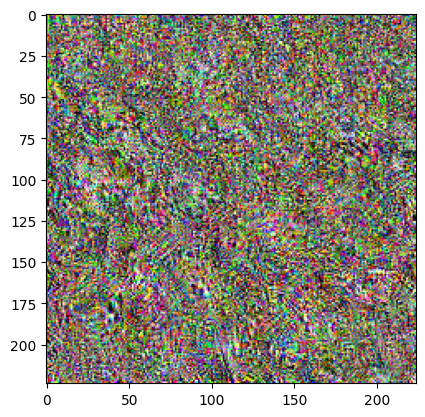

Iteration: 195, Loss: 0.002028008922934532
torch.Size([512])
torch.Size([512])
h is torch.Size([512])
v is torch.Size([512])
torch.Size([512])
torch.Size([512])
h is torch.Size([512])
v is torch.Size([512])
torch.Size([512])
torch.Size([512])
h is torch.Size([512])
v is torch.Size([512])
torch.Size([512])
torch.Size([512])
h is torch.Size([512])
v is torch.Size([512])


In [25]:
in4c_img_creator_meanatlas_onechannal_CustomLossWithRe = FeatureImgCreator(model,loss_fn=CustomLossWithRegularization(S=S,reg_coeff=0.05))
tmp_slices = slice(None)
in4c_img_creator_meanatlas_onechannal_CustomLossWithRe.imgae_create(torch.tensor(test_v).to(device),slices_set = tmp_slices, atlas_mode = 'means', steps = 200, learning_rate=0.05,show_step=5)

4. 使用MSE损失函数对某层**特定通道**下**的通道最大激活**针对目标激活进行优化

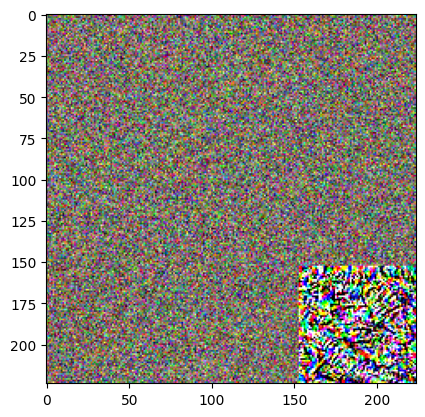

Iteration: 95, Loss: 958.4727783203125


In [39]:
in4c_img_creator_maxatlas_onechannal = FeatureImgCreator(model,loss_fn=torch.nn.MSELoss(reduction='mean'),initial_img = None)
tmp_slices = (20)
in4c_img_creator_maxatlas_onechannal.imgae_create(torch.tensor(test_v).to(device),slices_set = tmp_slices, atlas_mode = 'max', steps = 100, learning_rate=0.5,show_step=5)

In [109]:
tmp_mid_act = torch.randn(1, 512, 14, 14)
tmp_mean = torch.mean(tmp_mid_act, dim=(2, 3), keepdim=True).squeeze()
tmp_max = torch.max(tmp_mid_act.reshape(512,196), 1)[0]

In [110]:
tmp_max.shape

torch.Size([512])

Iteration: 0, Loss: 0.0034904642961919308
Iteration: 100, Loss: -0.005861865822225809
Iteration: 200, Loss: -0.006602676585316658
Iteration: 300, Loss: -0.007058178074657917
Iteration: 400, Loss: -0.00739253219217062
Iteration: 500, Loss: -0.007654645014554262
Iteration: 600, Loss: -0.007875487208366394
Iteration: 700, Loss: -0.008064746856689453
Iteration: 800, Loss: -0.008222782053053379
Iteration: 900, Loss: -0.008364828303456306
Iteration: 1000, Loss: -0.00849189329892397
Iteration: 1100, Loss: -0.00861011166125536
Iteration: 1200, Loss: -0.008720796555280685
Iteration: 1300, Loss: -0.00882557313889265
Iteration: 1400, Loss: -0.008923747576773167
Iteration: 1500, Loss: -0.009018953889608383
Iteration: 1600, Loss: -0.009108456782996655
Iteration: 1700, Loss: -0.0091925710439682
Iteration: 1800, Loss: -0.009275593794882298
Iteration: 1900, Loss: -0.009352421388030052
Iteration: 2000, Loss: -0.009428087621927261
Iteration: 2100, Loss: -0.009500408545136452
Iteration: 2200, Loss: -0.00

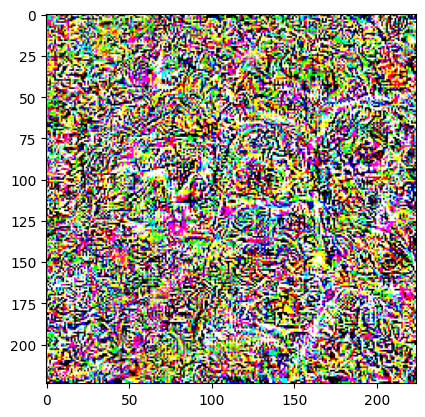

In [138]:
# 以均方差损失函数为损失函数
in4c_img_creator_mean = FeatureImgCreator(model,loss_fn=torch.nn.MSELoss(reduction='mean'))
in4c_img_creator_mean.imgae_create(torch.tensor(test_v).to(device),slices_set = 'means', steps = 20000, learning_rate=0.6,show_step=10)
# in4c_img_creator_mean.imshow()

KeyboardInterrupt: 

In [142]:
in4c_img_creator_max = FeatureImgCreator(model,loss_fn=torch.nn.MSELoss(reduction='mean'))

In [143]:
# in4c_img_creator_max = FeatureImgCreator(model,loss_fn=torch.nn.MSELoss(reduction='mean'))
in4c_img_creator_max.imgae_create(torch.tensor(test_v).to(device),slices_set = 'max', steps = 20000, learning_rate=0.6,show_step=5)
# in4c_img_creator_max.imshow()

KeyboardInterrupt: 

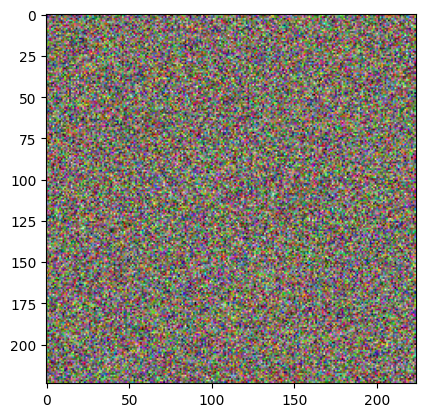

In [48]:
in4c_img_creator.imshow()

In [86]:
tmp = (0,slice(None),7,7)
in4c_img_creator.activation['inception4c'][tmp].shape

torch.Size([512])

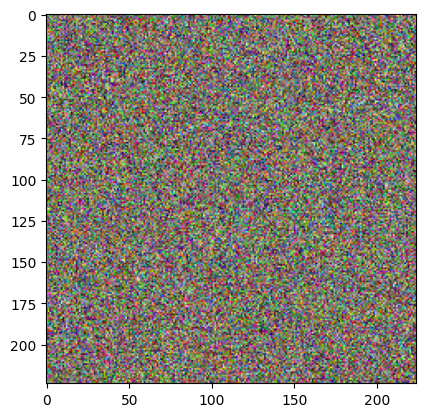

In [12]:
in4c_img_creator.imshow()

In [ ]:
def direction_neuron_S(layer, vec, batch=None, x=None, y=None, S=None):
    def inner():
        shape = layer.shape
        x_ = shape[1] // 2 if x is None else x
        y_ = shape[2] // 2 if y is None else y
        if batch is None:
            raise RuntimeError("requires batch")

        acts = layer[batch, x_, y_]
        vec_ = vec
        if S is not None:
            vec_ = torch.matmul(vec_.unsqueeze(0), S)[0]
        
        dot = torch.mean(acts * vec_)
        return dot
    return inner

#### 特征可视化

In [ ]:
from joblib import dump, load

# model.layers[7] is "mixed4c"
layer = "mixed4c"
# raw_activations = model.layers[7].activations
raw_activations = load('datas/raw_activations.joblib')
activations = raw_activations[:100000]
print(activations.shape)

(100000, 512)


数据白化


In [ ]:
def whiten(full_activations):
    correl = np.matmul(full_activations.T, full_activations) / len(full_activations)
    correl = correl.astype("float32")
    S = np.linalg.inv(correl)
    S = S.astype("float32")
    return S

In [ ]:
S = whiten(raw_activations)
S.shape

(512, 512)

归一化处理

In [ ]:
# 归一化处理 
def normalize_layout(layout, min_percentile=1, max_percentile=99, relative_margin=0.1):
    """Removes outliers and scales layout to between [0,1]."""

    # compute percentiles
    mins = np.percentile(layout, min_percentile, axis=(0))
    maxs = np.percentile(layout, max_percentile, axis=(0))

    # add margins
    mins -= relative_margin * (maxs - mins)
    maxs += relative_margin * (maxs - mins)

    # `clip` broadcasts, `[None]`s added only for readability
    clipped = np.clip(layout, mins, maxs)

    # embed within [0,1] along both axes
    clipped -= clipped.min(axis=0)
    clipped /= clipped.max(axis=0)

    return clipped

降维到二维

In [ ]:
layout = umap.UMAP(n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(activations)

## You can optionally use TSNE as well
# layout = TSNE(n_components=2, verbose=True, metric="cosine", learning_rate=10, perplexity=50).fit_transform(d)

layout = normalize_layout(layout)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Tue Mar  5 19:41:32 2024 Construct fuzzy simplicial set
Tue Mar  5 19:41:32 2024 Finding Nearest Neighbors
Tue Mar  5 19:41:32 2024 Building RP forest with 21 trees
Tue Mar  5 19:41:32 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Tue Mar  5 19:41:35 2024 Finished Nearest Neighbor Search
Tue Mar  5 19:41:35 2024 Construct embedding


KeyboardInterrupt: 

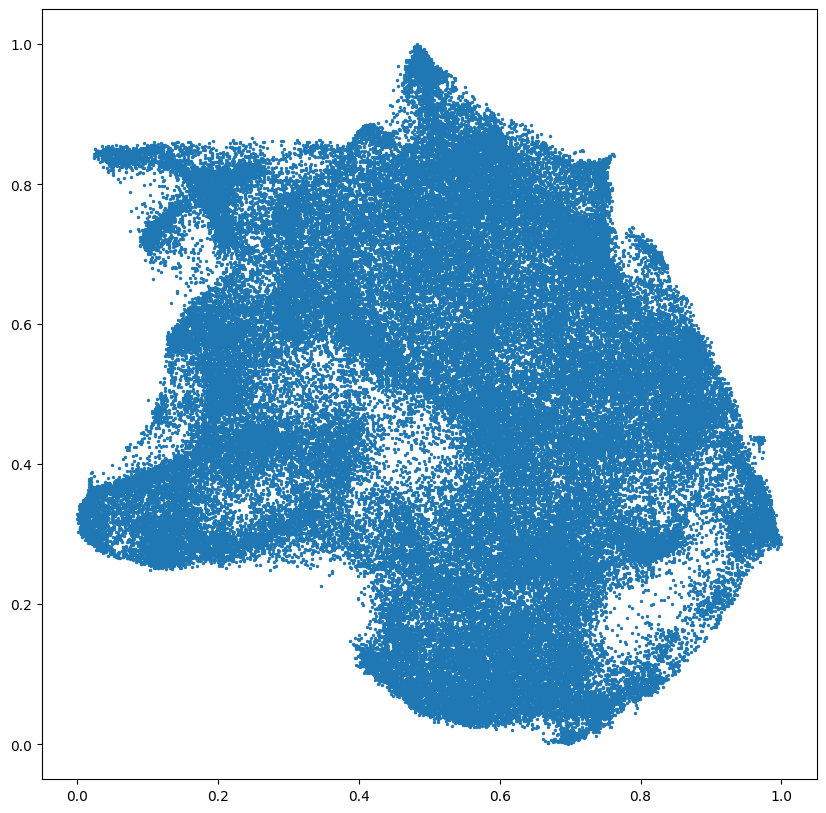

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x=layout[:,0],y=layout[:,1], s=2)
plt.show()

#### 特征可视化

#### 网格化

In [ ]:
# 
# Takes a list of x,y layout and bins them into grid cells
# 
def grid(xpts=None, ypts=None, grid_size=(8,8), x_extent=(0., 1.), y_extent=(0., 1.)):
    x_blocks = grid_size[0]
    y_blocks = grid_size[1]

    xpt_range = x_extent
    ypt_range = y_extent

    xpt_width= xpt_range[1] - xpt_range[0]
    ypt_width = ypt_range[1] - ypt_range[0]

    xpxs = ((xpts - xpt_range[0]) / xpt_width) * x_blocks
    ypxs = ((ypts - ypt_range[0]) / ypt_width) * y_blocks

    ix_s = range(grid_size[0])
    iy_s = range(grid_size[1])

    xs = np.empty((x_blocks, y_blocks), dtype=object)  # Modify this line to create an empty array with correct dimensions and type

    for xi in ix_s:
        for yi in iy_s:
            xpx_tmprange = (xi, (xi + 1))
            ypx_tmprange = (yi, (yi + 1))

            in_bounds_x = np.logical_and(xpx_tmprange[0] <= xpxs, xpxs < xpx_tmprange[1])
            in_bounds_y = np.logical_and(ypx_tmprange[0] <= ypxs, ypxs < ypx_tmprange[1])
            in_bounds = np.logical_and(in_bounds_x, in_bounds_y)

            in_bounds_indices = np.where(in_bounds)[0]
            xs[xi][yi] = in_bounds_indices
    return xs

可视化

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()
layer_name = 'inception4c'
layer = getattr(model, layer_name)

In [ ]:
model.inception4c

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): B

In [ ]:
def direction_neuron_S(layer_name, vec, batch=None, x=None, y=None, S=None):
    def inner(model):
        layer = getattr(model, layer_name)
        if batch is None:
            raise RuntimeError("requires batch")

        acts = layer[batch, :, x, y]  # Assuming layer is a 4D tensor (batch_size, channels, height, width)
        vec_ = vec
        if S is not None:
            vec_ = torch.matmul(vec_, S)
        dot = torch.mean(acts * vec_)
        return dot.item()  # Convert tensor to Python scalar
    return inner

def direction_neuron_cossim_S(layer_name, vec, batch=None, x=None, y=None, S=None, cossim_pow=4):
    def inner(model):
        layer = getattr(model, layer_name)
        if batch is None:
            raise RuntimeError("requires batch")

        acts = layer[batch, :, x, y]  # Assuming layer is a 4D tensor (batch_size, channels, height, width)
        vec_ = vec
        if S is not None:
            vec_ = torch.matmul(vec_, S)
        dot = torch.mean(acts * vec_)
        mag = torch.sqrt(torch.sum(acts**2))
        cossim = dot / (1e-4 + mag)
        cossim = cossim.pow(cossim_pow)
        return cossim.item()  # Convert tensor to Python scalar
    return inner
#
# Renders a batch of activations as icons
#
# directions为n*512的向量
def render_icons(directions, model, layer, size=80, n_steps=128, verbose=False, S=None, num_attempts=2, cossim=True, alpha=True):
    image_attempts = []
    loss_attempts = []

    # Render multiple attempts, and pull the one with the lowest loss score.
    for attempt in range(num_attempts):

      # Render an image for each activation vector
      param_f = lambda: param.image(size, batch=directions.shape[0], fft=True, decorrelate=True, alpha=alpha)
      if(S is not None):
          if(cossim is True):
              obj_list = ([
                direction_neuron_cossim_S(layer, v, batch=n, S=S, cossim_pow=4) for n,v in enumerate(directions)
              ]) 
          else: 
              obj_list = ([
                direction_neuron_S(layer, v, batch=n, S=S) for n,v in enumerate(directions)
              ])    
      else: 
          obj_list = ([
            objectives.direction_neuron(layer, v, batch=n) for n,v in enumerate(directions)
          ])

      obj = objectives.Objective.sum(obj_list)

      transforms = []
      if alpha:
          transforms.append(transform.collapse_alpha_random())
      transforms.append(transform.pad(2, mode='constant', constant_value=1))
      transforms.append(transform.jitter(4))
      transforms.append(transform.jitter(4))
      transforms.append(transform.jitter(8))
      transforms.append(transform.jitter(8))
      transforms.append(transform.jitter(8))
      transforms.append(transform.random_scale([0.995**n for n in range(-5,80)] + [0.998**n for n in 2*list(range(20,40))]))
      transforms.append(transform.random_rotate(list(range(-20,20))+list(range(-10,10))+list(range(-5,5))+5*[0]))
      transforms.append(transform.jitter(2))

      # This is the tensorflow optimization process.
      # We can't use the lucid helpers here because we need to know the loss.

      print("attempt: ", attempt)
      with tf.Graph().as_default(), tf.Session() as sess:
          learning_rate = 0.05
          losses = []
          trainer = tf.train.AdamOptimizer(learning_rate)
          T = render.make_vis_T(model, obj, param_f, trainer, transforms)
          loss_t, vis_op, t_image = T("loss"), T("vis_op"), T("input")
          losses_ = [obj_part(T) for obj_part in obj_list]
          tf.global_variables_initializer().run()
          for i in range(n_steps):
              loss, _ = sess.run([losses_, vis_op])
              losses.append(loss)
              if (i % 100 == 0):
                  print(i)

          img = t_image.eval()
          img_rgb = img[:,:,:,:3]
          if alpha:
              print("alpha true")
              k = 0.8
              bg_color = 0.0
              img_a = img[:,:,:,3:]
              img_merged = img_rgb*((1-k)+k*img_a) + bg_color * k*(1-img_a)
              image_attempts.append(img_merged)
          else:
              print("alpha false")
              image_attempts.append(img_rgb)

          loss_attempts.append(losses[-1])

    # Use the icon with the lowest loss
    loss_attempts = np.asarray(loss_attempts)   
    loss_final = []
    image_final = []
    print("Merging best scores from attempts...")
    for i, d in enumerate(directions):
        # note, this should be max, it is not a traditional loss
        mi = np.argmax(loss_attempts[:,i])
        image_final.append(image_attempts[mi][i])

    return (image_final, loss_final)

In [ ]:
def render_layout(model, layer, S, xs, ys, activ, n_steps=512, n_attempts=2, min_density=10, grid_size=(10, 10), icon_size=80, x_extent=(0., 1.0), y_extent=(0., 1.0)):
    grid_layout = grid(xpts=xs, ypts=ys, grid_size=grid_size, x_extent=x_extent, y_extent=y_extent)
    icons = []
    print(grid_size[0])
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            indices = grid_layout[x, y]
            if len(indices) > min_density:
                average_activation = np.average(activ[indices], axis=0)
                icons.append((average_activation, x, y))
                print("add one")
    return icons
    # icons = np.asarray(icons)
    # icon_batch, losses = render_icons(icons[:][0], model, alpha=False, layer=layer, S=S, n_steps=n_steps, size=icon_size, num_attempts=n_attempts)

    # canvas = np.ones((icon_size * grid_size[0], icon_size * grid_size[1], 3))
    # for i, icon in enumerate(icon_batch):
    #     y = int(icons[i, 1])
    #     x = int(icons[i, 2])
    #     canvas[(grid_size[0] - x - 1) * icon_size:(grid_size[0] - x) * icon_size, (y) * icon_size:(y + 1) * icon_size] = icon

    # return canvas

In [ ]:
raw_activations.shape

(100000, 512)

In [ ]:
tmp = render_layout(model, layer, S, xs, ys, raw_activations, n_steps=512, grid_size=(2, 2), n_attempts=1)

2
add one
add one
add one
add one


In [ ]:
testv = tmp[:][0][0]

In [ ]:
xs = layout[:, 0]
ys = layout[:, 1]

In [ ]:
tmp = grid(xs, ys, grid_size=(4,4), x_extent=(0., 1.), y_extent=(0., 1.))

In [ ]:
tmp.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
from PIL import Image
# 图像预处理
transform = transforms.Compose([
    transforms.Resize(256),                     # 调整图像大小为 256x256
    transforms.CenterCrop(224),                 # 中心裁剪为 224x224
    transforms.ToTensor(),                      # 将图像转换为张量，并归一化到 [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 标准化
])

# 加载图像并应用预处理
image_path = "datas/2014/val/ILSVRC2012_val_02691156.JPEG"  # 替换为你的图像路径
image = Image.open(image_path)
input_image = transform(image).unsqueeze(0)  # 添加一个批次维度

# 将图像输入模型
with torch.no_grad():
    output = model(input_image)

# 解释模型输出
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# 获取最大概率的类别索引
predicted_class = torch.argmax(probabilities).item()

# 打印结果
print("Predicted class:", predicted_class)

FileNotFoundError: [Errno 2] No such file or directory: 'datas/2014/val/ILSVRC2012_val_02691156.JPEG'

In [ ]:
output

tensor([[-4.4372e-01, -7.1926e-01, -5.6848e-01, -9.8426e-02,  1.4108e+00,
         -1.6783e-01, -1.0754e-01, -2.2054e+00, -1.8434e+00,  4.0641e-01,
         -2.0742e+00, -1.5640e+00, -1.4587e+00, -8.8022e-01, -1.2730e+00,
         -8.0162e-01, -9.9019e-01, -1.0220e+00,  4.2570e-01, -2.6872e-01,
         -1.6874e+00, -3.6968e-01, -4.7459e-01, -2.9467e-01,  2.8597e-02,
          5.4640e-01,  1.5822e+00, -3.7693e-01,  5.6126e-02, -1.1387e+00,
         -8.4445e-02, -2.4707e+00, -5.6476e-01,  2.3550e+00,  3.3302e+00,
          9.6415e-01,  1.8337e-01, -3.0971e-01,  1.7876e+00,  3.6845e-01,
         -1.3998e+00,  2.5401e+00,  1.0888e+00, -1.3681e-01,  4.5757e+00,
          1.4193e+00, -8.5087e-01, -4.1560e-01,  5.4828e-01,  5.4177e-01,
          1.4440e+00, -1.6479e+00,  7.4290e+00,  6.7018e+00,  6.8932e+00,
          3.8295e+00,  6.6960e+00,  7.0288e+00,  8.1170e+00,  4.1129e+00,
          8.9520e+00,  5.1895e+00,  6.2954e+00,  7.0092e+00,  3.9212e+00,
          8.4539e+00,  7.0404e+00,  6.

In [ ]:
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
def load_ImageNet(ImageNet_PATH, batch_size=64, workers=3, pin_memory=True): 
    
    traindir = os.path.join(ImageNet_PATH, 'train')

    print('traindir = ',traindir)

    
    normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalizer
        ])
    )


    
    print('train_dataset = ',len(train_dataset))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers,
        pin_memory=pin_memory,
        sampler=None
    )

    return train_loader, train_dataset



In [ ]:
load_ImageNet('tmp')

traindir =  tmp/train
train_dataset =  329320


(<torch.utils.data.dataloader.DataLoader at 0x7ff8508b8e20>,
 Dataset ImageFolder
     Number of datapoints: 329320
     Root location: tmp/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

#### 验证集标签处理

In [ ]:
from scipy.io import loadmat

data_dir = 'datas/2014'
# 读取meta.mat文件
meta_path = os.path.join(data_dir, "ILSVRC2014_devkit", "data", "meta_det.mat")
meta_data = loadmat(meta_path)

# 获取ImageNet类别列表
class_names = [meta_data['synsets'][i][0][1][0] for i in range(len(meta_data['synsets']))]


In [ ]:
meta_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Aug 15 16:24:40 2013',
 '__version__': '1.0',
 '__globals__': [],
 'synsets': array([[(array([[1]], dtype=uint8), array(['n02672831'], dtype='<U9'), array(['accordion'], dtype='<U9'), array(['a portable box-shaped free-reed instrument; the reeds are made to vibrate by air from the bellows controlled by the player)'],
               dtype='<U123'), array([], shape=(0, 0), dtype=uint8))                                                                                                                                                                             ,
         (array([[2]], dtype=uint8), array(['n02691156'], dtype='<U9'), array(['airplane'], dtype='<U8'), array([' an aircraft powered by propellers or jets'], dtype='<U42'), array([[366]], dtype=uint16)),
         (array([[3]], dtype=uint8), array(['n02219486'], dtype='<U9'), array(['ant'], dtype='<U3'), array([' emmet, pismire'], dtype='<U15'), array([], shape=